In [129]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [26]:
from one.api import ONE
one = ONE(mode='remote')

In [131]:
# Find all sessions with wheel position data using one.search
sess = list(one.search(project='brainwide', task_protocol='ephys', datasets='_ibl_wheel.position.npy'))
print(len(sess))
eid = sess[480]

485


In [132]:
# one.get_details(eid)
# one.list_datasets(eid=eid, query_type='remote')

In [133]:
# load an aggregate (group)
subject = 'SWC_043'
subject_trials = one.load_aggregate('subjects', subject, '_ibl_subjectTrials.table')

In [134]:
# import session loader
from brainbox.io.one import SessionLoader

In [135]:
# instantiate session loader
sl = SessionLoader(one=one, eid=eid)

In [136]:
# Load in trials data
sl.load_trials()

In [137]:
df = sl.trials

In [138]:
df.columns

Index(['stimOff_times', 'goCueTrigger_times', 'contrastLeft', 'feedbackType',
       'goCue_times', 'rewardVolume', 'feedback_times', 'firstMovement_times',
       'choice', 'contrastRight', 'stimOn_times', 'response_times',
       'probabilityLeft', 'intervals_0', 'intervals_1'],
      dtype='object')

In [139]:
df[['contrastLeft', 'contrastRight', 'choice', 'feedbackType']].head()
df[['goCue_times', 'stimOn_times', 'response_times', 'feedback_times']].head()

,goCue_times,stimOn_times,response_times,feedback_times
0,263.147867,263.146933,298.976548,298.976567
1,301.853700,301.852800,302.264579,302.264600
2,307.564367,307.563233,307.832244,307.832233
3,313.381000,313.379867,313.691905,313.692667
4,317.320333,317.319400,317.784543,317.785300


In [140]:
np.sort(df['contrastLeft'].unique())

array([0.    , 0.0625, 0.125 , 0.25  , 1.    ,    nan])

In [141]:
prob_left = df['probabilityLeft']

Text(0, 0.5, 'probability')

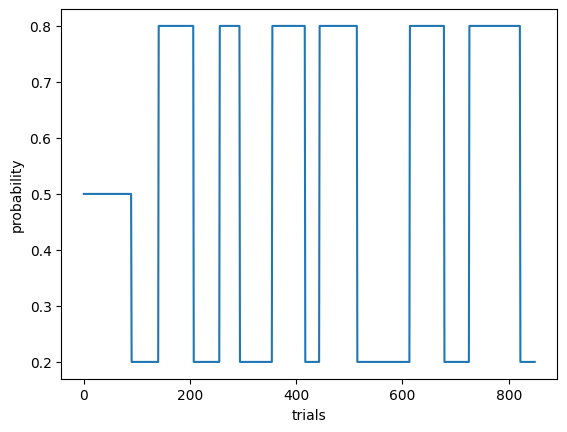

In [142]:
plt.plot(prob_left)
plt.xlabel('trials')
plt.ylabel('probability')

In [143]:
sl.load_wheel()

In [144]:
wheel_df = sl.wheel
wheel_df

,times,position,velocity,acceleration
0,1.597700,0.001534,0.000000,0.000000
1,1.598700,0.001517,-0.018902,-18.902266
2,1.599700,0.001499,-0.018869,0.032826
3,1.600700,0.001482,-0.018820,0.049762
4,1.601700,0.001464,-0.018755,0.064603
...,...,...,...,...
4647171,4648.768555,698.133057,0.000540,-0.092102
4647172,4648.769531,698.133057,0.000458,-0.082681
4647173,4648.770508,698.133057,0.000384,-0.073577
4647174,4648.771484,698.133057,0.000319,-0.064877


Average reaction time for stimulus on
Left: 0.6317719374101046
Right: 0.7673141311225427

Average reaction time on Left overall: 0.6318

Average reaction time on Right overall: 0.7673


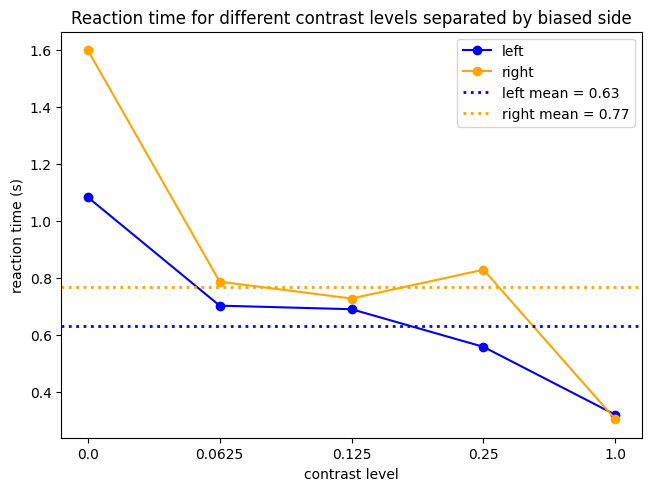

In [145]:
# Finding the reaction time
# Load in trials data
trials = one.load_object(eid, 'trials')

# Convert the trials dict to a pandas dataframe
trials_df = trials.to_df()

# Define reaction time as the time when the visual stimulus first appears and first movement time
reaction_time = trials['firstMovement_times'] - trials['stimOn_times']

# Evaluate reaction time across different trial types
# Compare reaction time for left vs right trials
left_trial_idx = ~np.isnan(trials['contrastLeft'])
right_trial_idx = ~np.isnan(trials['contrastRight'])
left_reaction_time = np.nanmean(reaction_time[left_trial_idx])
right_reaction_time = np.nanmean(reaction_time[right_trial_idx])
print(f'Average reaction time for stimulus on')
print(f'Left: {left_reaction_time}')
print(f'Right: {right_reaction_time}')

# check that the length of nan contrastLeft columns is the same as nonnan contrastRight columns
tot = trials_df.shape[0]
# print(np.sum(left_trial_idx)== tot-np.sum(right_trial_idx))

# compare reaction time for the magnitude of contrast for left and right separately
contrast_levels = np.sort(trials_df['contrastRight'].unique())
contrast_levels = contrast_levels[:5]
# contrast_levels = [0, 0.0625, 0.125, 0.25, 1]

# reaction time for each contrast level on the left
print(f'\nAverage reaction time on Left overall: {left_reaction_time:.4f}')
contrast_left_reaction_times = []
for i in range(len(contrast_levels)):
    contrast = contrast_levels[i]
    trial_idx = trials_df[trials_df['contrastLeft']==contrast].index
    left_reaction = np.nanmean(reaction_time[trial_idx])
    contrast_left_reaction_times.append(left_reaction)
    # print(f'Average reaction time for contrast level {contrast_levels[i]} is {left_reaction:.4f}.')

# reaction time for each contrast level on the right
contrast_right_reaction_times = []
print(f'\nAverage reaction time on Right overall: {right_reaction_time:.4f}')
for i in range(len(contrast_levels)):
    contrast = contrast_levels[i]
    trial_idx = trials_df[trials_df['contrastRight']==contrast].index
    right_reaction = np.nanmean(reaction_time[trial_idx])
    contrast_right_reaction_times.append(right_reaction)
    # print(f'Average reaction time for contrast level {contrast_levels[i]} is {right_reaction:.4f}.')

# plot the reaction time across contrast levels on left and right
fig, ax = plt.subplots(layout='constrained')
ax.plot(range(len(contrast_levels)), contrast_left_reaction_times, label='left', marker='o', color='blue')  # plot as if 0, 1, 2... are the x axis values
ax.plot(range(len(contrast_levels)), contrast_right_reaction_times, label='right', marker='o', color='orange')
plt.xticks(range(len(contrast_levels)), contrast_levels) # but label them with the contrast levels as if categorical
ax.set_xlabel('contrast level')
ax.set_ylabel('reaction time (s)')
ax.set_title('Reaction time for different contrast levels separated by biased side')
plt.axhline(y=left_reaction_time, color='blue', linestyle=':', linewidth=2, label=f'left mean = {left_reaction_time:.2f}')
plt.axhline(y=right_reaction_time, color='orange', linestyle=':', linewidth=2, label=f'right mean = {right_reaction_time:.2f}')
plt.legend()
plt.show()


In [146]:
# Compare reaction time for correct vs incorrect trials
correct_trial_idx = trials_df['feedbackType'] == 1
incorrect_trial_idx = trials_df['feedbackType'] == -1
correct_reaction_time = np.nanmean(reaction_time[correct_trial_idx])
incorrect_reaction_time = np.nanmean(reaction_time[incorrect_trial_idx])
print(f'\nAverage reaction time for trials that were')
print(f'Correct: {correct_reaction_time}')
print(f'Incorrect: {incorrect_reaction_time}')


Average reaction time for trials that were
Correct: 0.6095257215597006
Incorrect: 1.4420450755543721


### Class with functions for calculating reaction time across a session

In [147]:
class ReactionTime:
    """
    Computes the reaction times for any session. 

    Constructor params:
    reaction_type: defines the way to compute reaction time as either the difference between stimulus onset and first movement time (0)
    or the difference between stimulus onset and response time (1). 
    
    eid: the eid of the session. 
    
    Methods: 
    avg_reaction_time(self): computes and returns the average reaction time for all trials, and separated by left and right trials. 

    reaction_time_with_contrast(self, contrast_level, side=None): computes and returns the average reaction time for the specified 
    contrast level, where the contrast level must be a value in [0, 0.0625, 0.125, 0.25, 1]. 

    reaction_time_with_reward(self, reward): computes and returns the reaction time by the specified type of reward (rewarded or not). 
    Pass in reward=1 for rewarded trials and reward=0 for non-rewarded trials.


    """
    def __init__(self, reaction_type, eid):
        self.eid = eid  # Instance variable
        
        # load trial data
        trials = one.load_object(eid, 'trials')
        trials_df = trials.to_df()
        self.trials = trials_df  # make only the df accessible
        
        if reaction_type == 0:
            self.reaction_time = self.trials['firstMovement_times'] - self.trials['stimOn_times']
        elif reaction_type == 1:
            self.reaction_time = self.trials['firstMovement_times'] - self.trials['stimOn_times']
        else: 
            ValueError("reaction_type must be a value 0 or 1.")

    def avg_reaction_time(self):
        avg_reaction_time = np.nanmean(reaction_time)
        left_trial_idx = ~np.isnan(self.trials['contrastLeft'])
        right_trial_idx = ~np.isnan(self.trials['contrastRight'])
        left_reaction_time = np.nanmean(reaction_time[left_trial_idx])
        right_reaction_time = np.nanmean(reaction_time[right_trial_idx])
        print(f'Average reaction time for all trials: {avg_reaction_time:.4f}')
        print(f'Average reaction time for stimulus on')
        print(f'Left: {left_reaction_time}')
        print(f'Right: {right_reaction_time}')

    def reaction_time_with_contrast(self, contrast_level, side=None):
        contrast_levels = [0, 0.0625, 0.125, 0.25, 1]
        assert contrast_level in contrast_levels
        if side!= None:
            assert side in ['left', 'right']
            if side == 'left':
                trial_idx = self.trials[(self.trials['contrastLeft']==contrast)].index
                result = np.nanmean(reaction_time[trial_idx])
                print(f'\nAverage reaction time on {side} side for contrast level {contrast_level} is {result:.4f}.')
            else: 
                trial_idx = self.trials[(self.trials['contrastRight']==contrast)].index
                result = np.nanmean(reaction_time[trial_idx])
                print(f'\nAverage reaction time on {side} side for contrast level {contrast_level} is {result:.4f}.')
        else:
            trial_idx = self.trials[(self.trials['contrastLeft']==contrast) | (self.trials['contrastRight']==contrast)].index
            result = np.nanmean(reaction_time[trial_idx])
            print(f'\nAverage reaction time for contrast level {contrast_level} is {result:.4f}.')
    
    def reaction_time_with_reward(self, reward):
        assert reward in [1, 0]
        if reward==1: 
            correct_trial_idx = self.trials['feedbackType'] == 1
            correct_reaction_time = np.nanmean(reaction_time[correct_trial_idx])
            print(f'\nAverage reaction time for trials that were correct: {correct_reaction_time:.4f}')
        else: 
            incorrect_trial_idx = trials_df['feedbackType'] == -1
            incorrect_reaction_time = np.nanmean(reaction_time[incorrect_trial_idx])
            print(f'\nAverage reaction time for trials that were incorrect: {incorrect_reaction_time:.4f}')

In [148]:
rt = ReactionTime(reaction_type = 1, eid=eid)
rt.avg_reaction_time()
rt.reaction_time_with_contrast(contrast_level=1, side='right')
rt.reaction_time_with_reward(reward=1)

Average reaction time for all trials: 0.6957
Average reaction time for stimulus on
Left: 0.6317719374101046
Right: 0.7673141311225427

Average reaction time on right side for contrast level 1 is 0.3025.

Average reaction time for trials that were correct: 0.6095


Text(0, 0.5, 'Reaction time (s)')

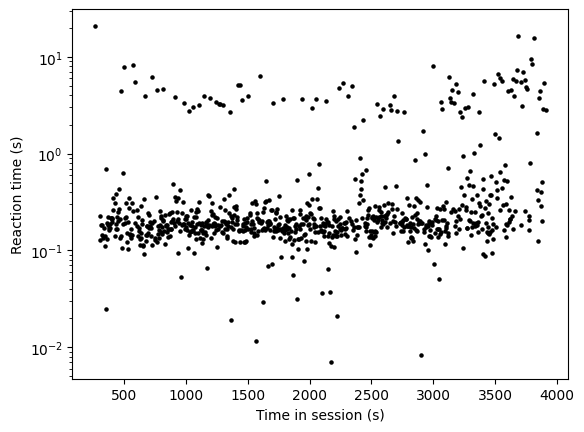

In [149]:
# 5. Make plot of reaction time across session
fig, ax = plt.subplots()
ax.scatter(trials['stimOn_times'], reaction_time, c='k', s=5)
ax.set_yscale("log")  # set y axis to log scale
ax.set_xlabel('Time in session (s)')
ax.set_ylabel('Reaction time (s)')

### PSTH for wheel movement around stimOn times

In [194]:
# PSTH for wheel velocity around stimOn times, comparison left and right sides. 

# Find times when first move is detected
events = np.array(sl.trials['stimOn_times'])

from brainbox.singlecell import bin_spikes
# Compute raster of wheel in 0.05s bins between 0.5s before the first move is detected to 1s after the first move is detected
bin_size = 0.05
pre_time = 0.2
post_time = 1
wheel_raster, times = bin_spikes(sl.wheel['times'], events, pre_time=pre_time, post_time=post_time, 
                                 bin_size=bin_size, weights=sl.wheel['velocity'])
# events

# separate by left and right trials
left_idx = ~np.isnan(sl.trials['contrastLeft'])
right_idx = ~np.isnan(sl.trials['contrastRight'])
wheel_psth_left = np.nanmean(wheel_raster[left_idx], axis=0)
wheel_psth_right = np.nanmean(wheel_raster[right_idx], axis=0)

# for all trials, not separated by left or right
psth_avg = np.mean(wheel_raster, axis=0) 

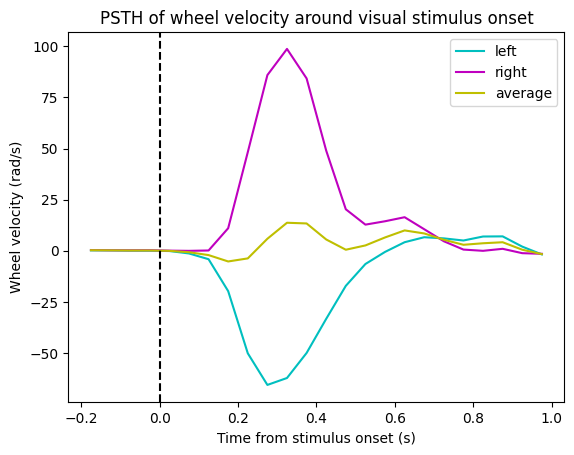

In [195]:
# Plot the psths
fig, axs = plt.subplots(gridspec_kw={'wspace': 0.5})
axs.plot(times, wheel_psth_left, c='c')
axs.plot(times, wheel_psth_right, c='m')
axs.plot(times, psth_avg, c='y', label='average')
axs.legend(['left', 'right', 'average'], )
axs.axvline(0, c='k', linestyle='--')
axs.set_xlabel('Time from stimulus onset (s)')
axs.set_ylabel('Wheel velocity (rad/s)')
plt.title('PSTH of wheel velocity around visual stimulus onset')
plt.show()

In [196]:
# compare PSTH across contrast levels for just left side
left_trials = trials_df[left_trial_idx]

psth_dict = {}

for level in contrast_levels:
    idx = np.where(left_trials['contrastLeft'] == level)[0]  # trials for this difficulty
    if len(idx) == 0:
        continue  # skip if no trials of this level

    bin_size = 0.025
    pre_time = 0.25
    post_time = 0.75

    wheel_raster, tscale = bin_spikes(
        sl.wheel['times'],
        events[idx],  # only trials for this difficulty
        pre_time=pre_time,
        post_time=post_time,
        bin_size=bin_size,
        weights=sl.wheel['velocity']  
    )

    psth = (wheel_raster.mean(axis=0), np.std(wheel_raster, axis=0) / np.sqrt(wheel_raster.shape[0]))
    psth_dict[level] = psth  # store for this level

# formatted for printing
np.set_printoptions(legacy='1.25')
psth_dict

# compute the standard error, which is defined as the stdev/sqrt(N)
# psth_stdev = np.std(wheel_raster, axis=0)
# psth_ste = psth_stdev / np.sqrt(wheel_raster.shape[0])
# psth_ste


{0.0: (array([ 0.18388639,  0.11942747,  0.07493592,  0.12584331,  0.14765201,
          0.12544484,  0.12855137,  0.10652155,  0.10682872,  0.09274178,
         -0.1270525 , -0.67112917, -1.24455518, -1.58660378, -1.86318417,
         -2.19000649, -2.31728242, -3.04465214, -5.11578387, -4.64644622,
         -0.61648528,  5.99499462, 12.18949923, 15.94044623, 16.81228837,
         13.72865046,  7.20811494,  0.29679256, -4.74089582, -8.84138173,
         -9.91860679, -6.39054837, -0.56530935,  4.90136485,  6.96791392,
          7.09191787,  4.77772394, -0.08512708, -4.17239813, -5.48777991]),
  array([0.08648599, 0.04881963, 0.08080398, 0.06010994, 0.04325555,
         0.06311312, 0.0450996 , 0.06396643, 0.06600225, 0.08594088,
         0.23610993, 0.694235  , 1.14864072, 1.33804814, 1.48331816,
         1.85584818, 2.57498471, 3.70560917, 5.59763818, 7.34868486,
         8.60084406, 9.08652005, 9.12330268, 8.89632035, 8.31680733,
         7.88374778, 7.84707458, 7.66920997, 7.09173626,

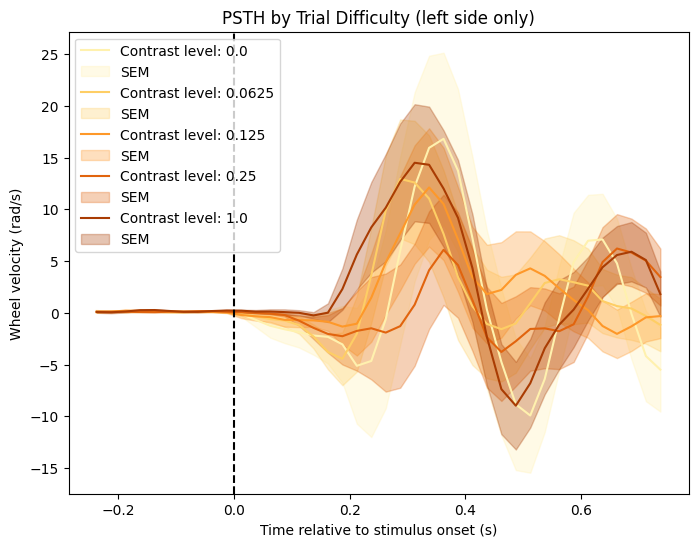

In [197]:
import seaborn as sns

plt.figure(figsize=(8, 6))
n_lines = len(psth_dict)

# Get discrete colors from the 'Blues' palette
palette = sns.color_palette("YlOrBr", n_lines)  # returns list of RGB tuples

idx = 0
for level, psth in psth_dict.items():
    plt.plot(tscale, psth[0], color=palette[idx], label=f'Contrast level: {level}')
    plt.fill_between(tscale, psth[0] - psth[1], psth[0] + psth[1],
                 color=palette[idx], alpha=0.3, label='SEM')
    idx += 1

plt.xlabel('Time relative to stimulus onset (s)')
plt.ylabel('Wheel velocity (rad/s)')
plt.title('PSTH by Trial Difficulty (left side only)')
plt.axvline(0, c='k', linestyle='--')
plt.legend()
plt.show()

In [198]:
# extract low contrast trials
low_contrast_trials = trials_df[(trials_df['contrastLeft']==0)|(trials_df['contrastRight']==0)]
# low_contrast_trials

In [199]:
# PSTH for different probabilities, but only for low contrast trials

probs = np.unique(low_contrast_trials['probabilityLeft'])

psth_probs = {}

for prob in probs:
    idx = np.where(low_contrast_trials['probabilityLeft'] == prob)[0]  # trials for this probability
    if len(idx) == 0:
        continue  # skip if no trials of this probability

    bin_size = 0.01
    pre_time = 0.5
    post_time = 1.25

    wheel_raster, tscale = bin_spikes(
        sl.wheel['times'],
        events[idx],  # only trials for this difficulty
        pre_time=pre_time,
        post_time=post_time,
        bin_size=bin_size,
        weights=sl.wheel['velocity']  
    )

    psth = wheel_raster.mean(axis=0)  # first dimension is trials, second dimension is time (one number for each bin)
    psth_probs[prob] = psth  # store for this level

# formatted for printing
np.set_printoptions(legacy='1.25')
# psth_probs


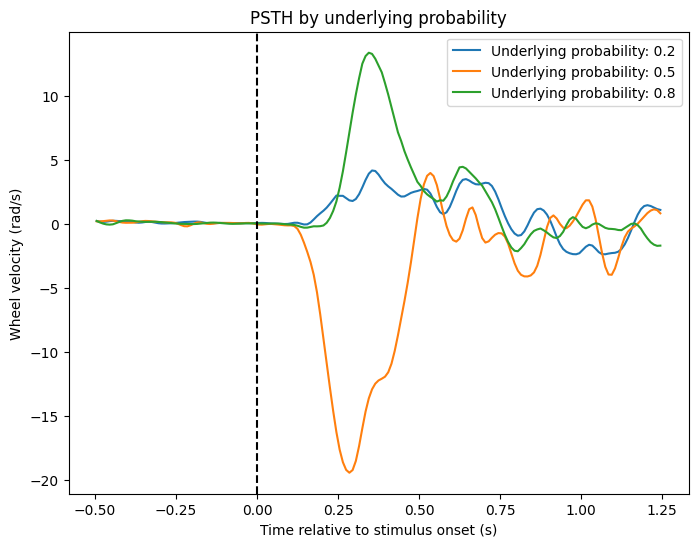

In [200]:
# plot psth
plt.figure(figsize=(8, 6))
for prob, psth in psth_probs.items():
    plt.plot(tscale, psth, label=f'Underlying probability: {prob}')

plt.xlabel('Time relative to stimulus onset (s)')
plt.ylabel('Wheel velocity (rad/s)')
plt.title('PSTH by underlying probability')
plt.axvline(0, c='k', linestyle='--')
plt.legend()
plt.show()

In [ ]:
# function for computing the PSTH for a given session
def get_psth(eid, events, bin_size=0.05, pre_time=0.5, post_time=1, side=None, contrast=None):

    gcamp_df = load_photometry(eid)
    trials_df = load_trials(eid)
    
    # load helper package
    from brainbox.singlecell import bin_spikes

    # Compute raster using bin_spikes

    times = list(gcamp_df.index) 
    events = np.array(trials_df[events]) # e.g. 'firstMovement_times'
    bin_size = bin_size
    pre_time = pre_time
    post_time = post_time
    raster, tscale = bin_spikes(times, events, pre_time=pre_time, post_time=post_time, 
                                    bin_size=bin_size, weights=gcamp_df.values[:,0])  
    
    if side=='left':
        left_idx = ~np.isnan(trials_df['contrastLeft'])
        psth_avg = np.nanmean(raster[left_idx], axis=0)

    elif side=='right':
        right_idx = ~np.isnan(trials_df['contrastRight'])
        psth_avg = np.nanmean(raster[right_idx], axis=0)
    
    else: 
        # average over all trials
        psth_avg = np.mean(raster, axis=0) 
    
    # contrast levels in a list
    if contrast!=None: 
        psth_contrast = {}
        for level in contrast:
            idx = np.where((trials_df['contrastLeft'] == level)|(trials_df['contrastRight'] == level))[0]  # trials for this difficulty
            if len(idx) == 0:
                continue  # skip if no trials of this level
        
            psth = np.nanmean(raster[idx], axis=0)
            psth_contrast[level] = psth  # store for this level

        return psth_avg, tscale, psth_contrast
    
    else: 
        return psth_avg, tscale
        

In [ ]:
# function for plotting PSTH, NEEDS FIXING

def plot_psth(eid, events, bin_size=0.05, pre_time=0.5, post_time=1, side=None, contrast=None):
    
    # set up the figure
    fig, axs = plt.subplots(1, 2, gridspec_kw={'wspace': 0.5})

    if contrast!=None: 
        psth_avg, tscale, psth_contrast = get_psth(eid, events, bin_size=bin_size, 
                                                pre_time=pre_time, post_time=post_time, 
                                                side=side, contrast=contrast)
        for level, psth in psth_contrast.items():
            axs[1].plot(tscale, psth, label=f'Contrast level: {level}')
    
    else:
        psth_avg, tscale = get_psth(eid, events, bin_size=bin_size, 
                                                pre_time=pre_time, post_time=post_time, 
                                                side=side, contrast=contrast)
        axs[0].plot(tscale, psth_avg, label = 'Average')
    
    axs[0].axvline(0, c='k', linestyle='--')
    axs[1].axvline(0, c='k', linestyle='--')
    axs[0].set_xlabel('Time relative to event (s)')
    axs[0].set_ylabel('Raster')
    plt.title('PSTH by Trial Difficulty (contrast level)')
    plt.legend()
    plt.show()  

## Photometry data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pathfile = '/Users/sarahhu/ibl_photometry/DR-5HT/'
metadf = pd.read_parquet(pathfile + 'sessions.pqt')
metadf.reset_index(inplace=True)
metadf.head()


,index,eid,subject,start_time,task_protocol,session_type,session_n,NM,target,roi
0,34,fe2a712b-014b-47e7-b2ac-f85d0571cf44,ZFM-03065,2021-08-27T10:18:12.784055,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,4,5HT,[DR],[Region1G]
1,35,ba01bf35-8a0d-4ca3-a66e-b3a540b21128,ZFM-03059,2021-08-27T11:18:32.529960,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,4,5HT,[DR],[Region1G]
2,38,f2a6559d-1e45-4e83-8f65-1295ef50ed4b,ZFM-03065,2021-08-30T08:29:50.008373,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,5,5HT,[DR],[Region1G]
3,42,c5cdd496-7400-4c0f-b326-55016bce4fcf,ZFM-03065,2021-08-31T10:23:23.726423,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,6,5HT,[DR],[Region1G]
4,49,fd22820d-a2c2-4c06-b90e-f399344e1c0a,ZFM-03059,2021-09-01T09:54:32.034120,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,7,5HT,[DR],[Region1G]


In [2]:
from one.api import ONE
one = ONE(mode='remote')

In [3]:
# select a random session eid
eid = metadf['eid'][2]

In [ ]:
test_trial = pd.read_parquet('/Users/sarahhu/ibl_photometry/DR-5HT/'+eid+'_trials.pqt')
test_trial['firstMovement_times']

pandas.core.series.Series

### Put everything in a class

In [145]:
from dataclasses import dataclass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

@dataclass
class Params: 
    """
    Parameters for PSTH and photometry analysis.

    Attributes
    ----------
    pre_time : float
        Time before event to include in the analysis window (in seconds).
    post_time : float
        Time after event to include in the analysis window (in seconds).
    bin_size : float
        Size of time bins for the histogram (in seconds).
    baseline_time : float
        Time window before the event used for baseline fluorescence calculation (in seconds).
    """
    pre_time: float=0.4
    post_time: float=1.0
    bin_size: float=0.01
    baseline_time: float=0.5

class Photometry: 
    """
    Class for analyzing photometry data aligned to behavioral events.

    Parameters
    ----------
    eid : str
        Experiment ID used to load data files.
    """

    def __init__(self, eid):
        self.eid = eid
        
        # private instances
        self.__pathfile = '/Users/sarahhu/ibl_photometry/DR-5HT/'
        self.__trials_df = self.load_trials()
        self.__gcamp_df = self.load_photometry()

        # public instances
        self.firstMovement_times = self.__trials_df['firstMovement_times']
        self.contrastRight = self.__trials_df['contrastRight']
        self.choice = self.__trials_df['choice']
        self.contrastLeft = self.__trials_df['contrastLeft']
        self.response_times = self.__trials_df['response_times']
        self.feedbackType = self.__trials_df['feedbackType']
        self.probabilityLeft = self.__trials_df['probabilityLeft']
        self.stimOn_times = self.__trials_df['stimOn_times']
        self.goCue_times = self.__trials_df['goCue_times']
        self.feedback_times = self.__trials_df['feedback_times']
        
    # functions for loading
    def load_photometry(self):
        df = pd.read_parquet(self.__pathfile + self.eid + '_gcamp.pqt')
        return df

    def load_trials(self): 
        df = pd.read_parquet(self.__pathfile + self.eid + '_trials.pqt')
        return df

    def load_isosbestic(self): 
        df = pd.read_parquet(self.__pathfile + self.eid + '_isosbestic.pqt')
        return df
    
    # Modified based on bin_spikes from brainbox.singlecell with help from ChatGPT
    def __bin_photometry(self, align_times, params: Params):

        # align_times = np.array(self.__trials_df[align_times])
       
        signal = self.__gcamp_df.values[:,0]
        times = list(self.__gcamp_df.index) 
        
        n_bins_pre = int(np.ceil(params.pre_time / params.bin_size))
        n_bins_post = int(np.ceil(params.post_time / params.bin_size))
        n_bins = n_bins_pre + n_bins_post
        tscale = np.arange(-n_bins_pre, n_bins_post + 1) * params.bin_size
        ts = np.repeat(align_times[:, np.newaxis], tscale.size, axis=1) + tscale
        epoch_idxs = np.searchsorted(times, np.c_[ts[:, 0], ts[:, -1]])
        bins = np.zeros(shape=(align_times.shape[0], n_bins))

        for i, (ep, t) in enumerate(zip(epoch_idxs, ts)):

            # Determine baseline period indices
            baseline_start = align_times[i] - params.baseline_time
            baseline_end = align_times[i]  # up to event onset
            baseline_idx = np.searchsorted(times, [baseline_start, baseline_end])

            # Compute baseline fluorescence (mean during baseline window)
            if baseline_idx[0] < baseline_idx[1]:  # ensure valid window
                F_baseline = np.mean(signal[baseline_idx[0]:baseline_idx[1]])
            else:
                F_baseline = np.nan  # if no points in baseline window

            # Compute fluorescence during trial window
            trial_signal = signal[ep[0]:ep[1]]
            xind = (np.floor((times[ep[0]:ep[1]] - t[0]) / params.bin_size)).astype(np.int64)
            
            r_counts = np.bincount(xind, minlength=tscale.shape[0])
            r_sum = np.bincount(xind, minlength=tscale.shape[0], weights=trial_signal)

            # avoid division by zero
            with np.errstate(divide='ignore', invalid='ignore'):
                r_mean = np.true_divide(r_sum, r_counts)
                r_mean[r_counts == 0] = np.nan  # if no data points in bin, set to NaN

            binned_signal = r_mean[:-1]  # remove the last bin 

            # Compute dF/F for this trial
            if not np.isnan(F_baseline) and F_baseline != 0:
                bins[i, :] = (binned_signal - F_baseline) / F_baseline * 100
            else:
                bins[i, :] = np.nan  # skip if baseline invalid or zero

        tscale = (tscale[:-1] + tscale[1:]) / 2

        return bins, tscale
    
    
    def get_psth(self, events, params: Params, side=None, contrast=None):
        """
        Compute PSTH aligned to a specific event with optional filtering by the side or contrast level in experimental setup. 

        Params
        -------
        events : str
            Column name of the event times to align to.
        params : Params
            Analysis parameters.
        side : str, optional
            'left' or 'right' trials.
        contrast : list, optional
            List of contrast levels to include.

        Returns
        -------
        psth_avg : np.ndarray of shape (n_bins,)
            The average binned dF/F (%) signal across all selected trials.
            
        tscale : np.ndarray of shape (n_bins,)
            The time points (in seconds) corresponding to the center of each bin.
            
        psth_contrast : dict of {float: np.ndarray of shape (n_bins,)}
            Dictionary mapping each contrast level to the average binned dF/F (%) signal 
            across all trials for that specific contrast level.
        """

        events = np.array(self.__trials_df[events])  # e.g. 'firstMovement_times'
        dF_F, tscale = self.__bin_photometry(events, params)  
        
        if side=='left':
            left_idx = ~np.isnan(self.__trials_df['contrastLeft'])
            trials = dF_F[left_idx]
            trials_data = self.__trials_df[left_idx]

        elif side=='right':
            right_idx = ~np.isnan(self.__trials_df['contrastRight'])
            trials = dF_F[right_idx]
            trials_data = self.__trials_df[right_idx]
        
        else: 
            # all trials
            trials = dF_F
            trials_data = self.__trials_df
        
        # take the average over all identified trials
        psth_avg = np.nanmean(trials, axis=0) 
        self._psth_sem = np.nanstd(trials, axis=0) / np.sqrt(trials.shape[0]) 
        
        # store psth for different contrast levels
        psth_contrast = {}
        self._psth_contrast_sem = {}
        
        if contrast!=None:
            contrast.sort()
            for level in contrast:
                # trial indices for this difficulty
                idx = np.where((trials_data['contrastLeft'] == level)|(trials_data['contrastRight'] == level))[0] 
                if len(idx) == 0:
                    continue  # skip if no trials of this level
        
                psth_contrast[level] = np.nanmean(trials[idx], axis=0) # store for this level
                self._psth_contrast_sem[level] = np.nanstd(trials[idx], axis=0) / np.sqrt(trials[idx].shape[0])
            
            return psth_avg, tscale, psth_contrast
        
        else:
            return psth_avg, tscale
    
    
    def plot_psth(self, events, params: Params):
        """
        Plot PSTH for all trials.
        """

        if not hasattr(self, '_psth_sem'):
            raise ValueError("Call get_psth() before plotting to compute SEM.")

        psth, tscale = self.get_psth(events, params)
        
        plt.figure(figsize=(8, 6))
        sem = self._psth_sem
        plt.plot(tscale, psth, c='g')
        plt.fill_between(tscale, psth - sem, psth + sem, color='g', alpha=0.2)
        plt.xlabel('Time (s)')
        plt.ylabel('ΔF/F(%)')
        plt.title(f'PSTH of Serotonin Signal relative to {events}')
        plt.axvline(0, c='k', linestyle='--')
        plt.show()
        

    def plot_psth_by_contrast_level(self, events, contrast, params: Params, side=None):
        """
        Plot PSTH by side or contrast levels.
        """
        
        if not hasattr(self, '_psth_sem'):
            raise ValueError("Call get_psth() before plotting to compute SEM.")

        tscale, psth_contrast = self.get_psth(events, params, contrast=contrast, side=side)[1:]
        
        plt.figure(figsize=(8, 6))
        n_lines = len(contrast)
        palette = sns.color_palette("YlOrBr", n_lines) 
        idx = 0

        for level, psth in psth_contrast.items():
            sem = self._psth_contrast_sem[level]
            plt.plot(tscale, psth, color=palette[idx], label=f'Contrast level: {level}')
            plt.fill_between(tscale, psth - sem, psth + sem,
                        color=palette[idx], alpha=0.2)
            idx += 1

        plt.xlabel('Time (s)')
        plt.ylabel('ΔF/F(%)')
        plt.title(f'PSTH of Serotonin Signaling Relative to {events} by Trial Difficulty')
        plt.axvline(0, c='k', linestyle='--')
        plt.legend()
        plt.show()

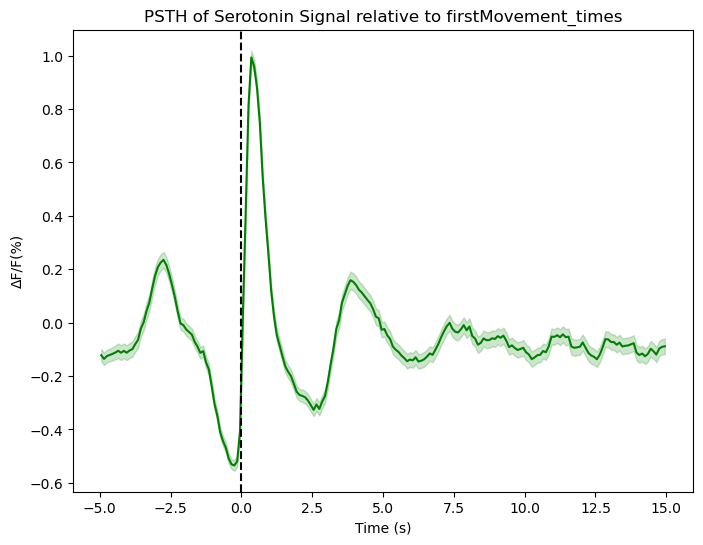

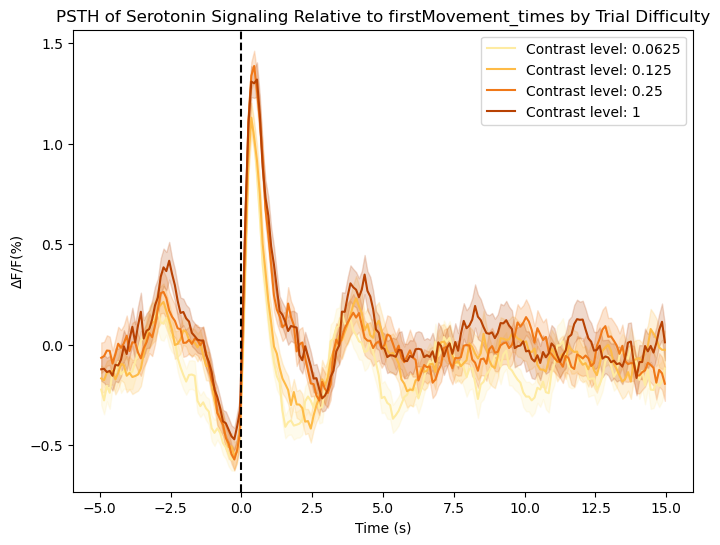

In [146]:
# test functions
session1 = Photometry(eid=metadf['eid'][30])

# print(session1.contrastLeft.unique())
params = Params(pre_time=5, post_time=15, bin_size=0.1, baseline_time=25)
psth_avg, tscale, psth_contrast = session1.get_psth('firstMovement_times', side='right', contrast=[1, 0.0625, 0.25, 0.125], params=params)

# print(psth_avg.shape)
# print(psth_contrast[1].shape)
# print(tscale.shape)
 
session1.plot_psth('firstMovement_times', params=params)
session1.plot_psth_by_contrast_level('firstMovement_times', side='right', contrast=[1, 0.0625, 0.25, 0.125], params=params)
